# Markov chain Monte Carlo: Amortized Approximate Likelihood Ratios

In [1]:
import hypothesis
import torch
import numpy as np
import matplotlib.pyplot as plt

## Forward model

In [2]:
from hypothesis.simulation import Simulator


class NormalSimulator(Simulator):
    
    def __init__(self):
        super(NormalSimulator, self).__init__()
        
    def forward(self, inputs):
        inputs = inputs.view(-1, 1)
        return torch.randn(inputs.size(0), 1) + inputs

simulator = NormalSimulator()

## Prior

In [3]:
from torch.distributions.uniform import Uniform

prior = Uniform(-30, 30)

## Likelihood-to-evidence ratio estimator

### Ratio estimator architecture

In [4]:
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceRatioEstimatorMLP as RatioEstimator

# Architecture definitions
activation = torch.nn.ELU
layers = [64, 64, 64]
inputs_shape = (1,)
outputs_shape = (1,)

# Allocation
ratio_estimator = RatioEstimator(
    activation=activation,
    shape_inputs=inputs_shape,
    shape_outputs=outputs_shape,
    layers=layers)
ratio_estimator = ratio_estimator.to(hypothesis.accelerator)
ratio_estimator = ratio_estimator.train()

### Training

In [5]:
from hypothesis.util.data import SimulatorDataset
from hypothesis.nn.amortized_ratio_estimation import LikelihoodToEvidenceCriterion as Criterion
from hypothesis.visualization.util import make_square

batch_size = 256
epochs = 25

dataset = SimulatorDataset(simulator, prior)
criterion = Criterion(estimator=ratio_estimator, batch_size=batch_size).to(hypothesis.accelerator)

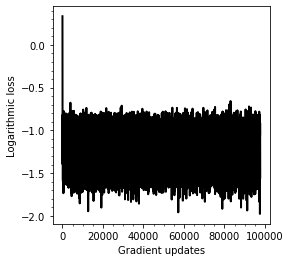

In [6]:
optimizer = torch.optim.Adam(ratio_estimator.parameters())

losses = []
for epoch in range(epochs):
    data_loader = torch.utils.data.DataLoader(dataset, num_workers=2, batch_size=batch_size, drop_last=True)
    num_batches = len(data_loader)
    data_loader = iter(data_loader)
    for batch_index in range(num_batches):
        optimizer.zero_grad()
        inputs, outputs = next(data_loader)
        inputs = inputs.to(hypothesis.accelerator)
        outputs = outputs.to(hypothesis.accelerator)
        loss = criterion(inputs=inputs, outputs=outputs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
losses = np.array(losses)
plt.plot(np.log(losses), lw=2, color="black")
plt.minorticks_on()
plt.xlabel("Gradient updates")
plt.ylabel("Logarithmic loss")
make_square(plt.gca())
plt.show()

In [7]:
ratio_estimator = ratio_estimator.cpu()
ratio_estimator.eval()

LikelihoodToEvidenceRatioEstimatorMLP(
  (mlp): MultiLayeredPerceptron(
    (mapping): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Sequential(
        (0): ELU(alpha=1.0)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Sequential(
        (0): ELU(alpha=1.0)
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## Posterior inference

In [8]:
observation = simulator(prior.sample())

## Scanning the parameter space

In [9]:
prior.log_prob(observation)

tensor([[-4.0943]])

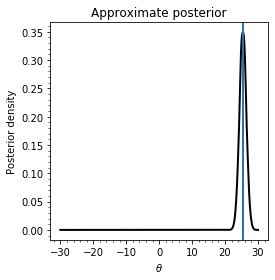

In [10]:
resolution = 1000
inputs = torch.linspace(-30, 30, resolution).view(-1, 1)
outputs = observation.repeat(1, resolution).view(-1, 1)

with torch.no_grad():
    log_posterior = ratio_estimator.log_ratio(inputs, outputs).view(-1) + prior.log_prob(observation).squeeze()
    
plt.plot(inputs.view(-1).numpy(), log_posterior.exp().numpy(), lw=2, color="black")
plt.axvline(observation.item(), lw=2, color="C0") # Mark the true MAP
plt.minorticks_on()
plt.xlabel(r"$\theta$")
plt.ylabel("Posterior density")
plt.title("Approximate posterior")
make_square(plt.gca())
plt.show()

## Markov chain Monte Carlo

In [11]:
from hypothesis.inference.transition_distribution import Normal as NormalTransition

transition = NormalTransition(1) # Proposal with unit standard deviation

In [12]:
from hypothesis.inference.mcmc import AALRMetropolisHastings

sampler = AALRMetropolisHastings(prior, ratio_estimator, transition)

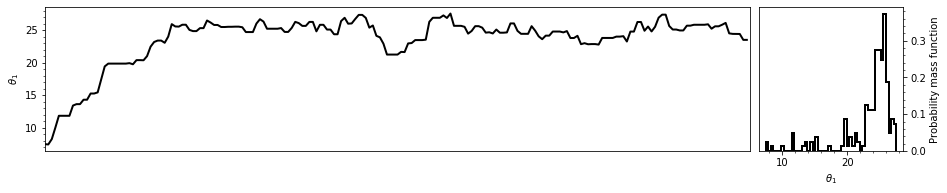

In [13]:
from hypothesis.visualization.mcmc import plot_trace

theta = prior.sample()
burnin_chain = sampler.sample(observation, theta, num_samples=200)

figure = plot_trace(burnin_chain)
plt.show()

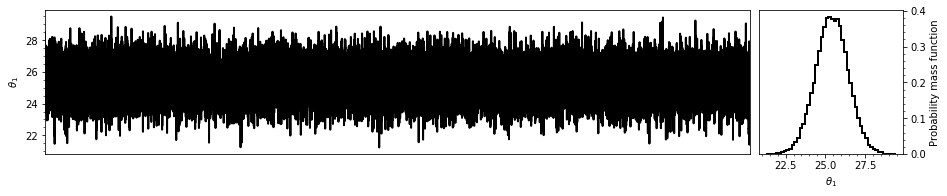

In [14]:
theta = burnin_chain[-1]
chain = sampler.sample(observation, theta, num_samples=100000)

figure = plot_trace(chain)
plt.show()

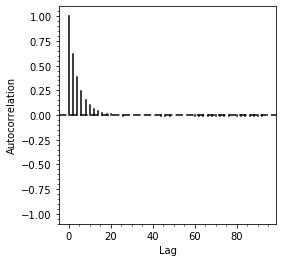

In [15]:
from hypothesis.visualization.mcmc import plot_autocorrelation

figure = plot_autocorrelation(chain, max_lag=100)
plt.show()

In [16]:
print("Effective size:", chain.effective_size())
print("Sampling efficiency:", chain.efficiency())

Effective size: 21114
Sampling efficiency: 0.21114


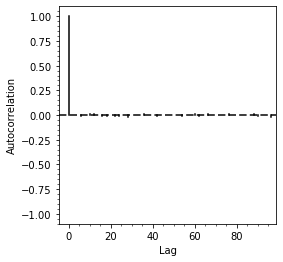

Effective size: 21114
Sampling efficiency: 1.0


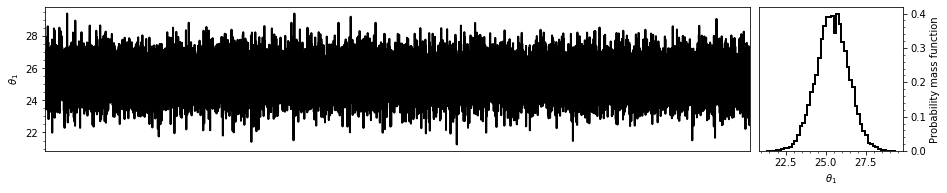

In [17]:
thinned_chain = chain.thin(proportion=chain.efficiency()) # Default behaviour, chain.thin() is equivalent.
figure = plot_autocorrelation(thinned_chain)
plt.show()

print("Effective size:", thinned_chain.effective_size())
print("Sampling efficiency:", thinned_chain.efficiency())

figure = plot_trace(thinned_chain)
plt.show()